# Lectura de Mediciones Transformadores

Notas:
1. Descargar de SITEC los archivos de Generacion de San Francisco
2. Graficar la Demanda x Trafos, la Generacion y la Suma
3. Graficar la tension en barra de 132 KV cuando entra la Generacion
4. Graficar la demanda en los trafos de Malvinas y relacionar

## Seteo Inicial

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Viernes 8 Octubre 2021 17:43:11 

@author: Daniel Busso
"""

# Plantilla de Pre Procesado

# Cómo importar las librerías
import numpy    as np
import pandas   as pd
import datetime as dt
import os

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import mean_absolute_percentage_error

#from skforecast.ForecasterAutoreg import ForecasterAutoreg
#from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
#from skforecast.model_selection import grid_search_forecaster
#from skforecast.model_selection import time_series_spliter
#from skforecast.model_selection import cv_forecaster
#from skforecast.model_selection import backtesting_forecaster
#from skforecast.model_selection import backtesting_forecaster_intervals

In [3]:
# Configuracion Pandas

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', '{:.2f}'.format)

In [4]:
def conversion_2400(fecha):
    if fecha[11:13] != '24':
        return pd.to_datetime(fecha, format='%d/%m/%Y %H:%M')

    fecha = fecha[0:11] + '00:' + fecha[14:]
    return pd.to_datetime(fecha, format='%d/%m/%Y %H:%M') + dt.timedelta(days=1)

## TD1

In [5]:
# EMPIEZO PROCESANDO UNA CARPETA
# AUTOMATIZAR LECTURAS DE VARIOS ARCHIVOS .PRN ANUALES
# lEER Y CONCATENAR LOS ARCHIVOS .prn DE LA CARPETA DSPractica/eetts/sanfrancisco/TD1

import os
import sys
from pathlib import Path

# ELEGIR PLATAFORMA WINDOWS LOCAL O GOOGLE COLABORATORY
if sys.platform == 'linux' :
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  carpeta_trabajo = Path('/content/drive/Othercomputers/LENOVO/DSPractica/eetts/san_francisco/TD1') # Google Colab
else:
  carpeta_inicio  = Path.home()
  carpeta_eett = Path("DSPractica/eetts/san_francisco/TD1")
  carpeta_trabajo = carpeta_inicio / carpeta_eett

archivos = list(carpeta_trabajo.glob('*.prn'))

# Automatizacion de los DataFrames 
i = 0
for nombre_completo in archivos:
    if (i == 0) :
        dfconca = pd.read_fwf(nombre_completo, header=0, decimal=',')
    else:
        dfdatos = pd.read_fwf(nombre_completo, header=0, decimal=',')
        dfconca = pd.concat([dfconca, dfdatos], ignore_index=True)
    i = i + 1
    
# BORRAMOS COLUMNAS NO USADAS
dfconca = dfconca.drop(columns=['Ampere', 'KVolt'])
dfconca

,Fecha,Hora,MW,MVAR,MVA
0,01/01/2011,00:15,-3.47,-0.31,3.48
1,01/01/2011,00:30,-8.98,-1.47,9.10
2,01/01/2011,00:45,-9.05,-1.46,9.17
3,01/01/2011,01:00,-9.03,-1.41,9.14
4,01/01/2011,01:15,-9.03,-1.36,9.13
...,...,...,...,...,...
632104,31/12/2020,23:40,-5.63,-1.68,5.88
632105,31/12/2020,23:45,-5.66,-1.72,5.92
632106,31/12/2020,23:50,-5.56,-1.56,5.78
632107,31/12/2020,23:55,-5.60,-1.59,5.82


In [6]:
# GENERAMOS INDICE DE FECHAS PARA MANEJAR LA SERIE DE TIEMPO
# Lectura y creacion del index DateTime para tratar el DataFrame como una Serie de Tiempo

dfconca['Fecha_Hora'] = dfconca['Fecha'] + ' ' + dfconca['Hora']
dfconca['Fecha_Hora'] = dfconca.Fecha_Hora.apply(conversion_2400) # CONVERSION DE HORA 24:00 ---> 00:00

dfconca.set_index('Fecha_Hora', inplace=True)
serie     = dfconca.drop(dfconca.index[-1]) # borro la fila del nuevo anio
serie_ord = serie.sort_index()
TD1 = serie_ord.copy()

# BORRAMOS Columnas Fecha Hora porque ya tenemos el Index Temporal
TD1 = TD1.drop(columns=['Fecha', 'Hora'])

# Renombramos Columnas
TD1.columns = ['TD1_MW', 'TD1_MVAR', 'TD1_MVA']
TD1

,TD1_MW,TD1_MVAR,TD1_MVA
Fecha_Hora,,,
2011-01-01 00:15:00,-3.47,-0.31,3.48
2011-01-01 00:30:00,-8.98,-1.47,9.10
2011-01-01 00:45:00,-9.05,-1.46,9.17
2011-01-01 01:00:00,-9.03,-1.41,9.14
2011-01-01 01:15:00,-9.03,-1.36,9.13
...,...,...,...
2020-12-31 23:35:00,-5.64,-1.72,5.90
2020-12-31 23:40:00,-5.63,-1.68,5.88
2020-12-31 23:45:00,-5.66,-1.72,5.92


## TD2 

In [7]:
# EMPIEZO PROCESANDO UNA CARPETA
# AUTOMATIZAR LECTURAS DE VARIOS ARCHIVOS .PRN ANUALES
# lEER Y CONCATENAR LOS ARCHIVOS .prn DE LA CARPETA DSPractica/eetts/sanfrancisco/TD2

import os
import sys
from pathlib import Path

# ELEGIR PLATAFORMA WINDOWS LOCAL O GOOGLE COLABORATORY
if sys.platform == 'linux' :
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  carpeta_trabajo = Path('/content/drive/Othercomputers/LENOVO/DSPractica/eetts/san_francisco/TD2') # Google Colab
else:
  carpeta_inicio  = Path.home()
  carpeta_eett = Path("DSPractica/eetts/san_francisco/TD2")
  carpeta_trabajo = carpeta_inicio / carpeta_eett

archivos = list(carpeta_trabajo.glob('*.prn'))

# Automatizacion de los DataFrames 
i = 0
for nombre_completo in archivos:
    if (i == 0) :
        dfconca = pd.read_fwf(nombre_completo, header=0, decimal=',')
    else:
        dfdatos = pd.read_fwf(nombre_completo, header=0, decimal=',')
        dfconca = pd.concat([dfconca, dfdatos], ignore_index=True)
    i = i + 1
    
# BORRAMOS COLUMNAS NO USADAS
dfconca = dfconca.drop(columns=['Ampere', 'KVolt'])
dfconca

,Fecha,Hora,MW,MVAR,MVA
0,01/01/2011,00:15,-3.56,-0.33,3.57
1,01/01/2011,00:30,-9.10,-1.47,9.22
2,01/01/2011,00:45,-9.16,-1.46,9.28
3,01/01/2011,01:00,-9.15,-1.40,9.25
4,01/01/2011,01:15,-9.16,-1.36,9.26
...,...,...,...,...,...
632057,31/12/2020,23:40,-0.14,-0.09,0.16
632058,31/12/2020,23:45,-0.14,-0.08,0.16
632059,31/12/2020,23:50,-0.13,-0.09,0.16
632060,31/12/2020,23:55,-0.14,-0.09,0.16


In [8]:
# GENERAMOS INDICE DE FECHAS PARA MANEJAR LA SERIE DE TIEMPO
# Lectura y creacion del index DateTime para tratar el DataFrame como una Serie de Tiempo

dfconca['Fecha_Hora'] = dfconca['Fecha'] + ' ' + dfconca['Hora']
dfconca['Fecha_Hora'] = dfconca.Fecha_Hora.apply(conversion_2400) # CONVERSION DE HORA 24:00 ---> 00:00

dfconca.set_index('Fecha_Hora', inplace=True)
serie     = dfconca.drop(dfconca.index[-1]) # borro la fila del nuevo anio
serie_ord = serie.sort_index()
TD2 = serie_ord.copy()

# BORRAMOS Columnas Fecha Hora porque ya tenemos el Index Temporal
TD2 = TD2.drop(columns=['Fecha', 'Hora'])

# Renombramos Columnas
TD2.columns = ['TD2_MW', 'TD2_MVAR', 'TD2_MVA']
TD2

,TD2_MW,TD2_MVAR,TD2_MVA
Fecha_Hora,,,
2011-01-01 00:15:00,-3.56,-0.33,3.57
2011-01-01 00:30:00,-9.10,-1.47,9.22
2011-01-01 00:45:00,-9.16,-1.46,9.28
2011-01-01 01:00:00,-9.15,-1.40,9.25
2011-01-01 01:15:00,-9.16,-1.36,9.26
...,...,...,...
2020-12-31 23:35:00,-0.14,-0.09,0.17
2020-12-31 23:40:00,-0.14,-0.09,0.16
2020-12-31 23:45:00,-0.14,-0.08,0.16


## TD3

In [9]:
# EMPIEZO PROCESANDO UNA CARPETA
# AUTOMATIZAR LECTURAS DE VARIOS ARCHIVOS .PRN ANUALES
# lEER Y CONCATENAR LOS ARCHIVOS .prn DE LA CARPETA DSPractica/eetts/sanfrancisco

import os
import sys
from pathlib import Path

# ELEGIR PLATAFORMA WINDOWS LOCAL O GOOGLE COLABORATORY
if sys.platform == 'linux' :
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  carpeta_trabajo = Path('/content/drive/Othercomputers/LENOVO/DSPractica/eetts/san_francisco/TD3') # Google Colab
else:
  carpeta_inicio  = Path.home()
  carpeta_eett = Path("DSPractica/eetts/san_francisco/TD3")
  carpeta_trabajo = carpeta_inicio / carpeta_eett

archivos = list(carpeta_trabajo.glob('*.prn'))

# Automatizacion de los DataFrames 
i = 0
for nombre_completo in archivos:
    if (i == 0) :
        dfconca = pd.read_fwf(nombre_completo, header=0, decimal=',')
    else:
        dfdatos = pd.read_fwf(nombre_completo, header=0, decimal=',')
        dfconca = pd.concat([dfconca, dfdatos], ignore_index=True)
    i = i + 1
    
# BORRAMOS COLUMNAS NO USADAS
dfconca = dfconca.drop(columns=['Ampere', 'KVolt'])
dfconca

,Fecha,Hora,MW,MVAR,MVA
0,04/01/2017,02:05,0.00,0.00,0.00
1,04/01/2017,02:10,0.00,0.00,0.00
2,04/01/2017,02:15,0.00,0.00,0.00
3,04/01/2017,02:20,0.00,0.00,0.00
4,04/01/2017,02:25,0.00,0.00,0.00
...,...,...,...,...,...
412265,31/12/2020,23:40,10.23,-1.99,10.42
412266,31/12/2020,23:45,10.30,-1.99,10.49
412267,31/12/2020,23:50,10.12,-1.84,10.29
412268,31/12/2020,23:55,10.10,-1.84,10.27


In [10]:
# GENERAMOS INDICE DE FECHAS PARA MANEJAR LA SERIE DE TIEMPO

dfconca['Fecha_Hora'] = dfconca['Fecha'] + ' ' + dfconca['Hora']
dfconca['Fecha_Hora'] = dfconca.Fecha_Hora.apply(conversion_2400) # CONVERSION DE HORA 24:00 ---> 00:00

dfconca.set_index('Fecha_Hora', inplace=True)
serie     = dfconca.drop(dfconca.index[-1]) # borro la fila del nuevo anio
serie_ord = serie.sort_index()
TD3 = serie_ord.copy()

# BORRAMOS Columnas Fecha Hora porque ya tenemos el Index Temporal
TD3 = TD3.drop(columns=['Fecha', 'Hora'])

# Renombramos Columnas
TD3.columns = ['TD3_MW', 'TD3_MVAR', 'TD3_MVA']
TD3

,TD3_MW,TD3_MVAR,TD3_MVA
Fecha_Hora,,,
2017-01-04 02:05:00,0.00,0.00,0.00
2017-01-04 02:10:00,0.00,0.00,0.00
2017-01-04 02:15:00,0.00,0.00,0.00
2017-01-04 02:20:00,0.00,0.00,0.00
2017-01-04 02:25:00,0.00,0.00,0.00
...,...,...,...
2020-12-31 23:35:00,10.28,-1.99,10.47
2020-12-31 23:40:00,10.23,-1.99,10.42
2020-12-31 23:45:00,10.30,-1.99,10.49


## Concatenar TD1 + TD2 + TD3 para despues sumar 

In [11]:
# CONCATENAR TD1 + TD2 + TD3
#
Trafos = pd.concat([TD1, TD2, TD3], axis = 1)

# Reemplazar np.nan con ceros
Trafos = Trafos.replace(np.nan,0)

# Suma Potencia Aparente
Trafos['Suma'] = Trafos['TD1_MVA'] + Trafos['TD2_MVA'] + Trafos['TD3_MVA']

Trafos

,TD1_MW,TD1_MVAR,TD1_MVA,TD2_MW,TD2_MVAR,TD2_MVA,TD3_MW,TD3_MVAR,TD3_MVA,Suma
Fecha_Hora,,,,,,,,,,
2011-01-01 00:15:00,-3.47,-0.31,3.48,-3.56,-0.33,3.57,0.00,0.00,0.00,7.05
2011-01-01 00:30:00,-8.98,-1.47,9.10,-9.10,-1.47,9.22,0.00,0.00,0.00,18.32
2011-01-01 00:45:00,-9.05,-1.46,9.17,-9.16,-1.46,9.28,0.00,0.00,0.00,18.45
2011-01-01 01:00:00,-9.03,-1.41,9.14,-9.15,-1.40,9.25,0.00,0.00,0.00,18.39
2011-01-01 01:15:00,-9.03,-1.36,9.13,-9.16,-1.36,9.26,0.00,0.00,0.00,18.39
...,...,...,...,...,...,...,...,...,...,...
2020-12-31 23:35:00,-5.64,-1.72,5.90,-0.14,-0.09,0.17,10.28,-1.99,10.47,16.54
2020-12-31 23:40:00,-5.63,-1.68,5.88,-0.14,-0.09,0.16,10.23,-1.99,10.42,16.46
2020-12-31 23:45:00,-5.66,-1.72,5.92,-0.14,-0.08,0.16,10.30,-1.99,10.49,16.57


In [12]:
#
# Grafica del Pico Maximo Potencia Aparente x DIA

def Grafica_xDia_Mensual(pi, pf):
    plt.style.use('fivethirtyeight')
    
    #y = datos.loc[anio:anio, 'MVA'].resample('D').max()
    #x = y.index
    
    gg = Trafos.loc[pi:pf, ['TD1_MVA', 'TD2_MVA', 'TD3_MVA', 'Suma']]
    

    x = gg['TD1_MVA']
    y = gg['TD2_MVA']
    z = gg['TD3_MVA']
    s = gg['Suma']
    t = x.index 
    
    fig = plt.figure()
    fig, grafico = plt.subplots(figsize=(30, 5))
    
    #grafico.plot(x, y, lw=1, label='Potencia Aparente', marker='o')
    grafico.plot(t, x, lw=1, label='TD1', marker='o', color='g')
    grafico.plot(t, y, lw=1, label='TD2', marker='o', color='y')
    grafico.plot(t, z, lw=1, label='TD3', marker='o', color='b')
    grafico.plot(t, s, lw=2, label='TD1+TD2+TD3', marker='o', color='k')
    
    grafico.set_xlabel('[ Meses ]')  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]')  # Add a y-label to the axes.
    grafico.set_title("POTENCIA APARENTE DIARIA " + pi + pf)  # Add a title to the axes.
    grafico.legend()  # Add a legend.
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid()
    
    #fig.savefig("Serie_Anual_xDia_"+anio+".png")

<Figure size 432x288 with 0 Axes>

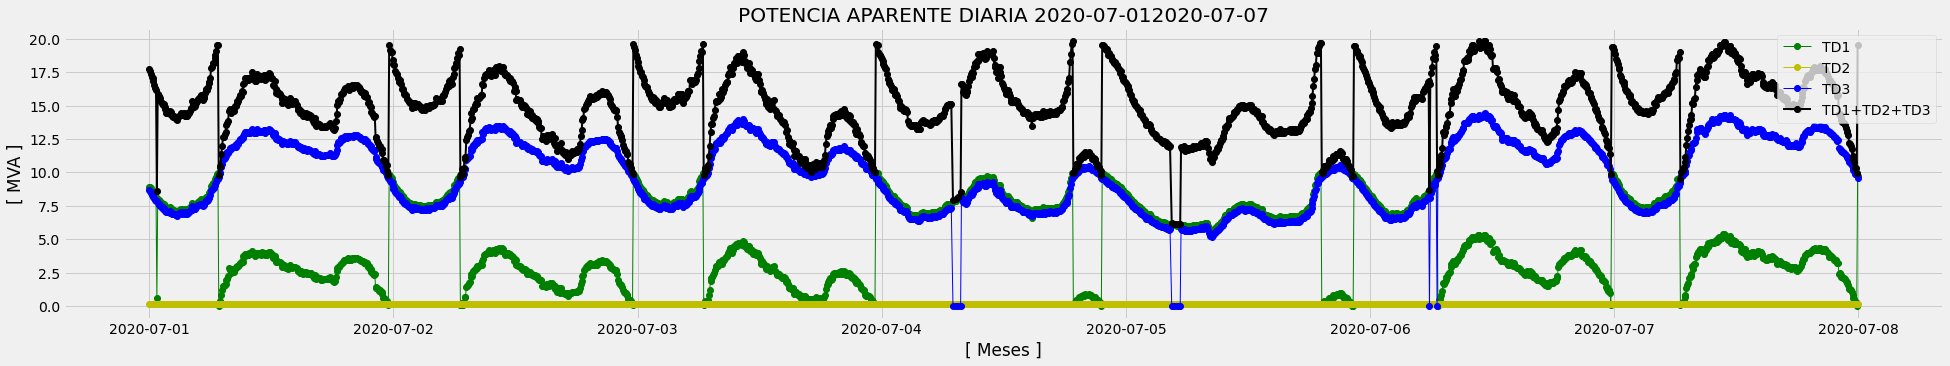

In [13]:
Grafica_xDia_Mensual('2020-07-01', '2020-07-07')

## Obtengo los Valores Maximos x Dia TD1_MVA TD2_MVA TD3_MVA Suma 

In [14]:
#
# Generar Pot_max_xdia para todos los anios

# Obtengo los Valores Maximos x Dia  ---- No puedo utilizar resample('D') porque me da los valores Maximos para todas las columnas
# y yo necesito los valores MVA para los cuales Suma es maxima en el Dia

Pot_max_xdia = pd.DataFrame(columns = ['TD1_MVA', 'TD2_MVA', 'TD3_MVA', 'Suma'])

#anios = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
anio_ini = '2011'
anio_fin = '2020'
pi = anio_ini + '-01-01'
pf = anio_fin + '-12-31'

dias = pd.date_range(start=pi, end=pf, freq='D')
for dia in dias:
    dia = dia.strftime('%Y/%m/%d')
    if Trafos.loc[dia, :].empty :
        pass
    else:
        ind = Trafos.loc[dia, 'Suma'].idxmax()
        Pot_max_xdia.loc[ind] = Trafos.loc[ind, ['TD1_MVA', 'TD2_MVA', 'TD3_MVA', 'Suma']] 

Pot_max_xdia

,TD1_MVA,TD2_MVA,TD3_MVA,Suma
2011-01-01 13:15:00,10.55,10.69,0.00,21.24
2011-01-02 14:00:00,10.01,10.12,0.00,20.13
2011-01-03 08:45:00,12.37,12.49,0.00,24.86
2011-01-04 08:15:00,12.78,12.84,0.00,25.62
2011-01-05 10:45:00,12.13,12.27,0.00,24.40
...,...,...,...,...
2020-12-26 17:00:00,9.84,0.17,17.94,27.95
2020-12-28 13:20:00,7.93,0.15,23.92,32.00
2020-12-29 13:55:00,5.58,0.15,19.65,25.38
2020-12-30 21:15:00,9.45,0.16,13.31,22.92


In [15]:
# Grafica del Pico Maximo Potencia Aparente x DIA

def Grafica_xDia(pi, pf):
    plt.style.use('fivethirtyeight')
        
    #pi = anio + '-07-01'
    #pf = anio + '-07-31'
    
    x = Pot_max_xdia.loc[pi:pf, 'TD1_MVA']
    y = Pot_max_xdia.loc[pi:pf, 'TD2_MVA']
    z = Pot_max_xdia.loc[pi:pf, 'TD3_MVA']
    s = Pot_max_xdia.loc[pi:pf, 'Suma']
    t = x.index 
    
    fig = plt.figure()
    fig, grafico = plt.subplots(figsize=(30, 5))
    
    #grafico.plot(x, y, lw=1, label='Potencia Aparente', marker='o')
    grafico.plot(t, x, lw=1, label='TD1', marker='o', color='g')
    grafico.plot(t, y, lw=1, label='TD2', marker='o', color='y')
    grafico.plot(t, z, lw=1, label='TD3', marker='o', color='b')
    grafico.plot(t, s, lw=2, label='TD1+TD2+TD3', marker='o', color='k')
    
    grafico.set_xlabel('[ Meses ]')  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]')  # Add a y-label to the axes.
    grafico.set_title("POTENCIA APARENTE DIARIA " + pi + pf)  # Add a title to the axes.
    grafico.legend()  # Add a legend.
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid()
    
    #fig.savefig("Serie_Anual_xDia_"+anio+".png")

<Figure size 432x288 with 0 Axes>

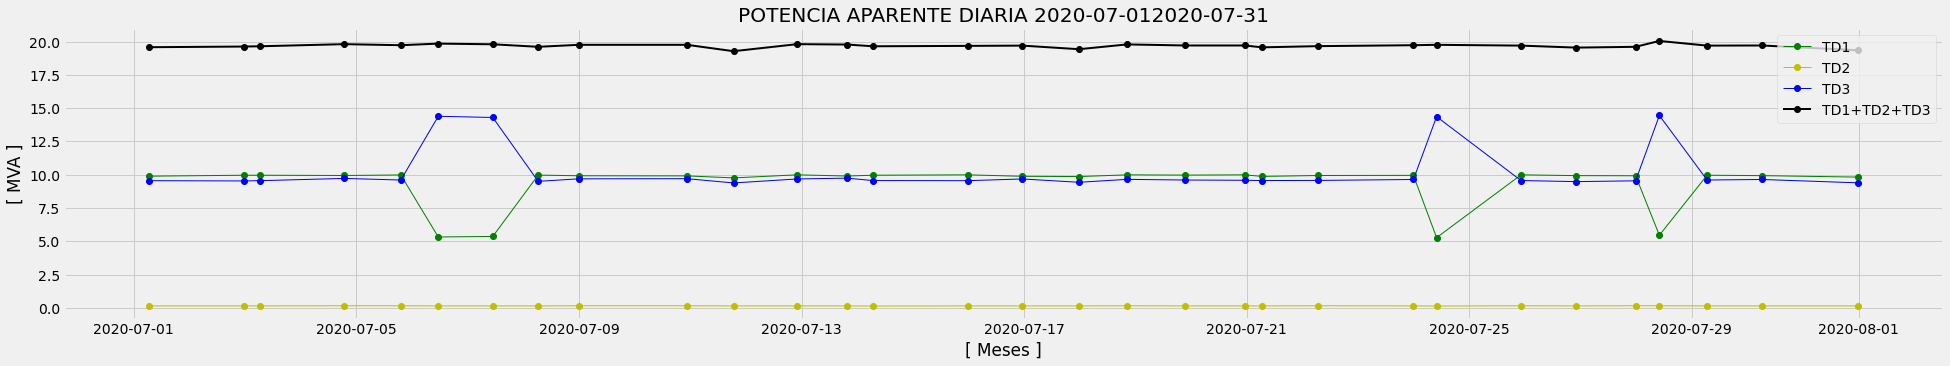

In [16]:
Grafica_xDia('2020-07-01', '2020-07-31')

<Figure size 432x288 with 0 Axes>

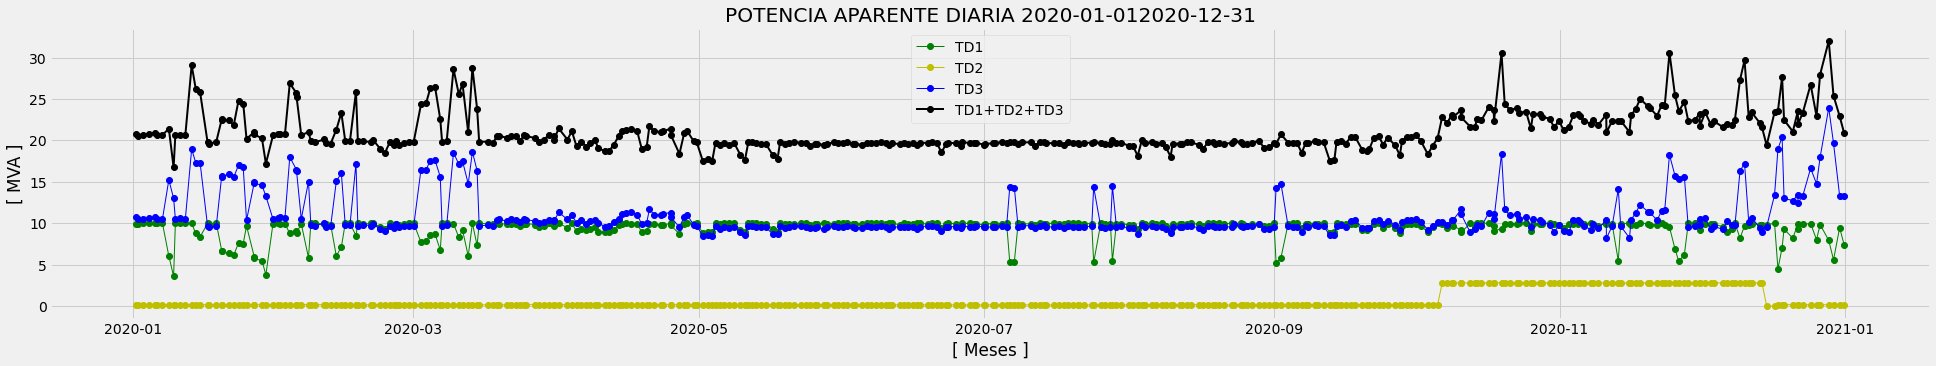

In [17]:
Grafica_xDia('2020-01-01', '2020-12-31')

<Figure size 432x288 with 0 Axes>

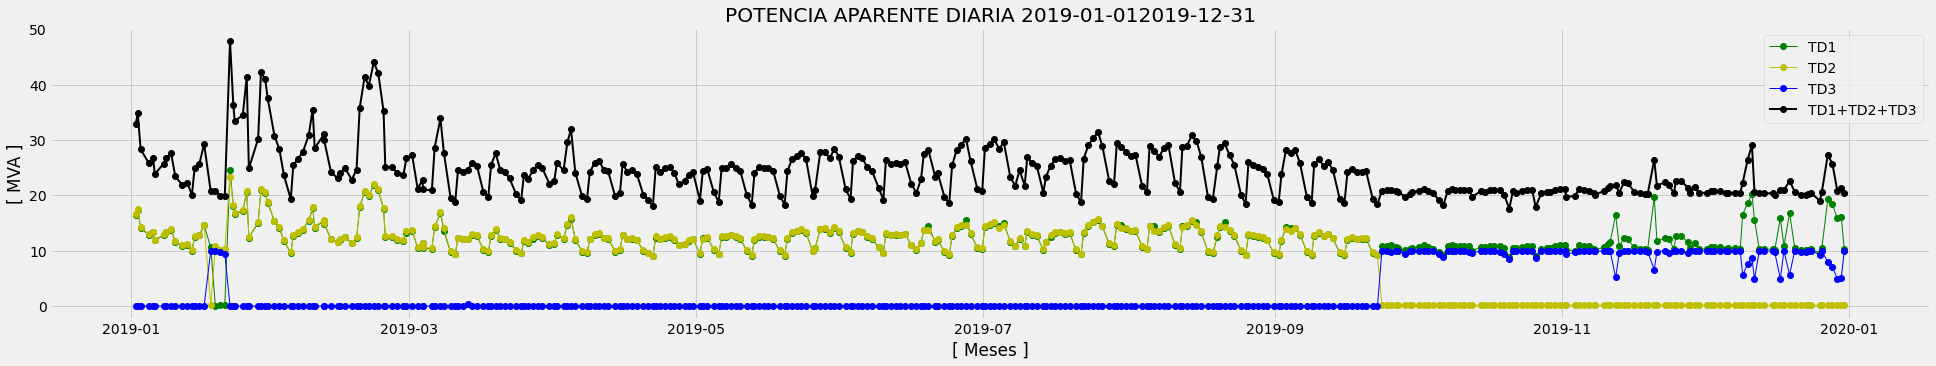

In [18]:
Grafica_xDia('2019-01-01', '2019-12-31')

In [19]:
#
# Generar Pot_Max_xMes para todos los anios

# Obtengo los Valores Maximos x MES  ---- No puedo utilizar resample('D') porque me da los valores Maximos para todas las columnas
# y yo necesito los valores MVA para los cuales Suma es maxima en el MES

#anios = ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']

Pot_max_xmes = pd.DataFrame(columns = ['TD1_MVA', 'TD2_MVA', 'TD3_MVA', 'Suma'])

anio_ini = '2011'
anio_fin = '2020'
pi = anio_ini + '-01-01'
pf = anio_fin + '-12-31'

meses = pd.date_range(start=pi, end=pf, freq='M')
for mes in meses:
    mes = mes.strftime('%Y/%m')
    if Trafos.loc[mes, :].empty :
        pass
    else:
        ind = Trafos.loc[mes, 'Suma'].idxmax()
        Pot_max_xmes.loc[ind] = Trafos.loc[ind, ['TD1_MVA', 'TD2_MVA', 'TD3_MVA', 'Suma']] 

Pot_max_xmes.tail()

,TD1_MVA,TD2_MVA,TD3_MVA,Suma
2020-08-03 17:00:00,9.99,0.18,9.84,20.01
2020-09-02 10:35:00,5.80,0.13,14.79,20.72
2020-10-19 14:25:00,9.36,2.79,18.37,30.52
2020-11-24 12:15:00,9.52,2.79,18.25,30.56
2020-12-28 13:20:00,7.93,0.15,23.92,32.00


In [20]:
# Grafica del Pico Maximo Potencia Aparente x DIA

def Grafica_Pot_Max_xMes(pi, pf):
    plt.style.use('fivethirtyeight')
        
    TD1 = Pot_max_xmes.loc[pi:pf, 'TD1_MVA']
    TD2 = Pot_max_xmes.loc[pi:pf, 'TD2_MVA']
    TD3 = Pot_max_xmes.loc[pi:pf, 'TD3_MVA']
    Suma = Pot_max_xmes.loc[pi:pf, 'Suma']
    tiempo = TD1.index 
    
    fig = plt.figure()
    fig, grafico = plt.subplots(figsize=(30, 10))
    
    #grafico.plot(x, y, lw=1, label='Potencia Aparente', marker='o')
    grafico.plot(tiempo, TD1, lw=1, label='TD1', marker='o', color='g')
    grafico.plot(tiempo, TD2, lw=1, label='TD2', marker='o', color='y')
    grafico.plot(tiempo, TD3, lw=1, label='TD3', marker='o', color='b')
    grafico.plot(tiempo, Suma, lw=2, label='TD1+TD2+TD3', marker='o', color='k')
    
    grafico.set_xlabel('[ Meses ]')  # Add an x-label to the axes.
    grafico.set_ylabel('[ MVA ]')  # Add a y-label to the axes.
    grafico.set_title("POTENCIA APARENTE DIARIA " + pi + pf)  # Add a title to the axes.
    grafico.legend()  # Add a legend.
    #grafico.annotate('Pico Max', xy=(01-31 14:45, 75), xytext=(01-31 15:00, 75), arrowprops=dict(facecolor='black', shrink=0.05)
    #grafico.grid()
    
    #fig.savefig("Serie_Anual_xDia_"+anio+".png")

<Figure size 432x288 with 0 Axes>

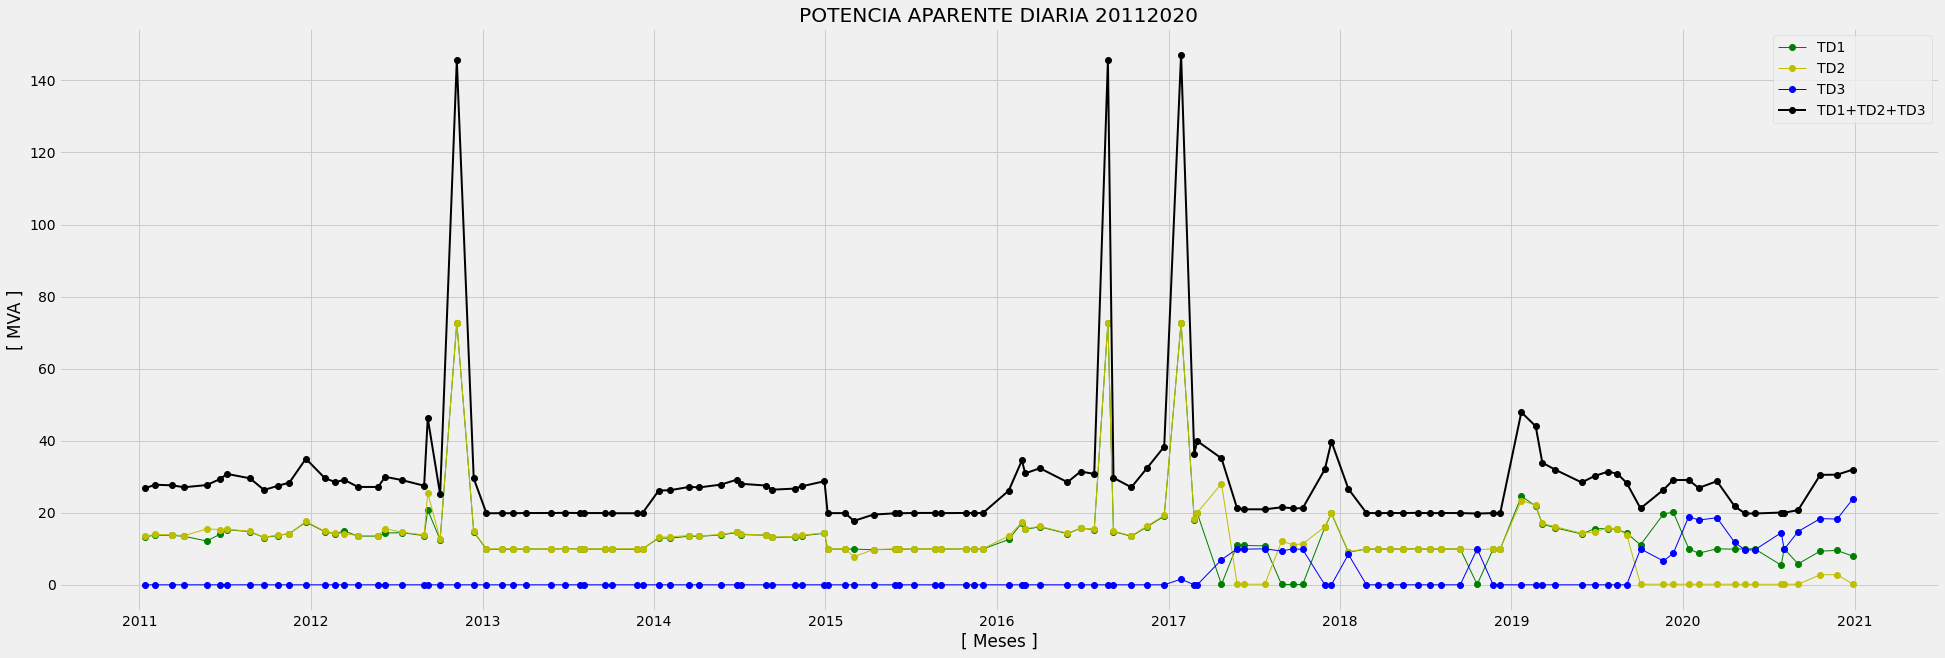

In [21]:
Grafica_Pot_Max_xMes('2011','2020')

In [28]:
Pot_max_xmes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2011-01-12 09:15:00 to 2020-12-28 13:20:00
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   TD1_MVA  120 non-null    float64
 1   TD2_MVA  120 non-null    float64
 2   TD3_MVA  120 non-null    float64
 3   Suma     120 non-null    float64
dtypes: float64(4)
memory usage: 8.8 KB


In [30]:
Pot_max_xmes.tail()

,TD1_MVA,TD2_MVA,TD3_MVA,Suma
2020-08-03 17:00:00,9.99,0.18,9.84,20.01
2020-09-02 10:35:00,5.80,0.13,14.79,20.72
2020-10-19 14:25:00,9.36,2.79,18.37,30.52
2020-11-24 12:15:00,9.52,2.79,18.25,30.56
2020-12-28 13:20:00,7.93,0.15,23.92,32.00


# Deteccion de Outliers

In [22]:
pi = '2011'
pf = '2020'

Suma = Pot_max_xmes.loc[pi:pf, 'Suma']
len(Suma)

120

In [23]:
Suma.describe()

count   120.00
mean    29.13 
std     19.78 
min     17.73 
25%     19.93 
50%     27.05 
75%     29.61 
max     147.16
Name: Suma, dtype: float64

In [24]:
Suma.std()

19.78105864438092

In [25]:
media = Suma.mean()
desv  = Suma.std()
Lim_Sup = media + 3 * desv

Lim_Sup

88.47567593314275

In [26]:
if dato > Lim_Sup:
    

SyntaxError: unexpected EOF while parsing (<ipython-input-26-ffbf2012c064>, line 2)

In [ ]:
TD1.loc['2013', 'TD1_MVA'].idxmax()

In [ ]:
TD1.loc['2013-01-17', :]

## Chequeo si hay Registros / Filas Faltantes
Si dife distinto de cero, significa que faltan registros/filas en los datos del SITEC

NOTA: Por el momento, no vamos a imputar estos Datos Faltantes

In [ ]:
#dti2 = pd.date_range(start='2017-01-01 00:15:00', end='2018-01-01 00:00:00', freq="15min")
indice = pd.date_range(start=TD1.index[0], end=TD1.index[-1], freq="15min")
dife   = indice.difference(TD1.index)
dife

In [ ]:
if dife.empty == False:
    print('Faltan algunas Mediciones: ', len(dife), '% Incompletas= ', (len(dife)/len(indice)*100), '% Completas= ', \
          (((len(indice)-len(dife))/len(indice))*100))
else:
    print('Mediciones Completas: ', (((len(indice)-len(dife))/len(indice))*100))

In [ ]:
#datos2 = datos.drop(['Fecha', 'Hora'], axis=1)
#data.drop(['Fecha', 'Hora', 'Ampere', 'KVolt'], axis=1)
#datos2.iloc[0:100, :]